In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import numpy as np
import matplotlib.pyplot as plt
import train_mlp_numpy as trainer
import seaborn as sns

from sklearn.datasets import make_moons
from mlp_numpy import MLP
from modules import CrossEntropy

# Default constants
DNN_HIDDEN_UNITS_DEFAULT = '20'
LEARNING_RATE_DEFAULT = 1e-2
MAX_EPOCHS_DEFAULT = 1500
EVAL_FREQ_DEFAULT = 10
METHOD_DEFAULT = 'BGD'

parser = argparse.ArgumentParser()
parser.add_argument('--dnn_hidden_units', type=str, default=DNN_HIDDEN_UNITS_DEFAULT,
                    help='Comma separated list of number of units in each hidden layer')
parser.add_argument('--learning_rate', type=float, default=LEARNING_RATE_DEFAULT,
                    help='Learning rate')
parser.add_argument('--max_steps', type=int, default=MAX_EPOCHS_DEFAULT,
                    help='Number of epochs to run trainer.')
parser.add_argument('--eval_freq', type=int, default=EVAL_FREQ_DEFAULT,
                    help='Frequency of evaluation on the test set')
parser.add_argument('--method', choices=['BGD', 'SGD'], default='BGD',
                    help='Method of gradient descent')
FLAGS, unparsed = parser.parse_known_args()

In [2]:
def make_data(noise: float, n=1000, train_size=0.8, shuffle=True):
    train_data_size = int(n * train_size)
    x, y = make_moons(n_samples=n, shuffle=shuffle, noise=noise)
    y = np.column_stack((y, 1 - y))
    x_train, x_test = x[:train_data_size], x[train_data_size:]
    y_train, y_test = y[:train_data_size], y[train_data_size:]
    return x_train, x_test, y_train, y_test


def accuracy(predictions: np.ndarray, targets: np.ndarray):
    """
    Computes the prediction accuracy, i.e., the average of correct predictions
    of the network.
    Args:
        predictions: 2D float array of size [number_of_data_samples, n_classes]
        targets: 2D int array of size [number_of_data_samples, n_classes] with one-hot encoding of ground-truth labels
    Returns:
        accuracy: scalar float, the accuracy of predictions.
    """
    cnt = 0
    for i in range(len(predictions)):
        if (np.around(predictions[i]) == targets[i]).all():
            cnt += 1
    return cnt / len(predictions)


def accuracy_loss(mlp: MLP, data: np.ndarray, label: np.ndarray, criterion: CrossEntropy):
    loss = 0
    predict = []
    for x, y in zip(data, label):
        y_hat = mlp.forward(x)
        loss += criterion.forward(y_hat, y)
        predict.append(y_hat)
    return accuracy(np.array(predict), label), loss / len(data)


def train(x_train,
          x_test,
          y_train,
          y_test):
    """
    Performs training and evaluation of MLP model.
    NOTE: You should the model on the whole test set each eval_freq iterations.
    """
    print(FLAGS)
    # YOUR TRAINING CODE GOES HERE
    x_axis = []
    train_accuracy, train_loss, test_accuracy, test_loss = [], [], [], []

    n_hidden = list(map(lambda ele: int(ele), FLAGS.dnn_hidden_units.split(',')))
    lr = FLAGS.learning_rate
    epochs = FLAGS.max_steps
    eval_freq = FLAGS.eval_freq
    method = FLAGS.method

    batch_size = x_train.shape[0]
    mlp = MLP(2, n_hidden, 2, batch_size, lr)
    criterion = CrossEntropy()
    for epoch in range(epochs):
        mlp.zero_grad()
        for i in range(batch_size):
            i = i if method == 'BGD' else np.random.randint(0, batch_size)
            x, y = x_train[i], y_train[i]

            y_hat = mlp.forward(x)
            dx = criterion.backward(y_hat, y)
            mlp.backward(dx)
            if method == 'SGD': mlp.step()
        if method == 'BGD': mlp.step()

        if epoch % eval_freq == 0:
            x_axis.append(epoch)

            acc, loss = accuracy_loss(mlp, x_train, y_train, criterion)
            train_accuracy.append(acc)
            train_loss.append(loss)
            acc, loss = accuracy_loss(mlp, x_test, y_test, criterion)
            test_accuracy.append(acc)
            test_loss.append(loss)

            print(f'Epoch {x_axis[-1]}\n'
                  f'Train Accuracy: {train_accuracy[-1]} \t Train Loss: {train_loss[-1]}\n'
                  f'Test Accuracy: {test_accuracy[-1]} \t Test Loss: {test_loss[-1]}\n')

    plt.plot(x_axis, train_accuracy, label='train accuracy')
    plt.plot(x_axis, train_loss, label='train loss')
    plt.plot(x_axis, test_accuracy, label='test accuracy')
    plt.plot(x_axis, test_loss, label='test loss')
    plt.legend()
    plt.show()

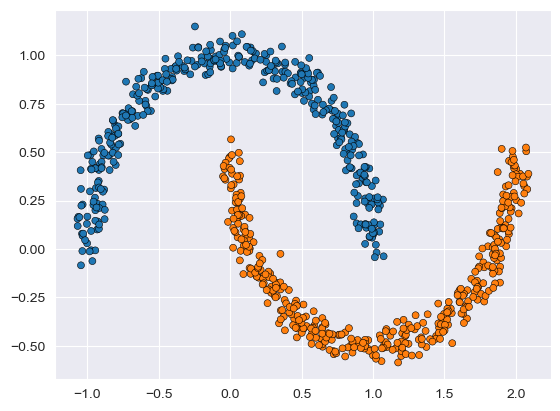

In [3]:
x_train, x_test, y_train, y_test = trainer.make_data(0.05)
sns.scatterplot(x=x_train[:, 0], y=x_train[:, 1], hue=y_train[:, 0], markers='o', s=25, edgecolor='k', legend=False)
plt.show()

# Training using **Batched Gradient Descent**

Namespace(dnn_hidden_units='20', eval_freq=10, learning_rate=0.01, max_steps=1500, method='BGD')
Epoch 0
Train Accuracy: 0.575 	 Train Loss: 0.8182035584890512
Test Accuracy: 0.575 	 Test Loss: 0.8268421824529617

Epoch 10
Train Accuracy: 0.635 	 Train Loss: 0.6267097204890856
Test Accuracy: 0.615 	 Test Loss: 0.6380325599501533

Epoch 20
Train Accuracy: 0.705 	 Train Loss: 0.5174786936893744
Test Accuracy: 0.665 	 Test Loss: 0.5279787418027638

Epoch 30
Train Accuracy: 0.7825 	 Train Loss: 0.4493041901108974
Test Accuracy: 0.775 	 Test Loss: 0.4593621507726061

Epoch 40
Train Accuracy: 0.875 	 Train Loss: 0.40463968946085316
Test Accuracy: 0.86 	 Test Loss: 0.41477189209335696

Epoch 50
Train Accuracy: 0.87625 	 Train Loss: 0.37397015633220243
Test Accuracy: 0.865 	 Test Loss: 0.3844946189833401

Epoch 60
Train Accuracy: 0.875 	 Train Loss: 0.3519100237603472
Test Accuracy: 0.855 	 Test Loss: 0.36301541088599154

Epoch 70
Train Accuracy: 0.87625 	 Train Loss: 0.3352807926319344
Test A

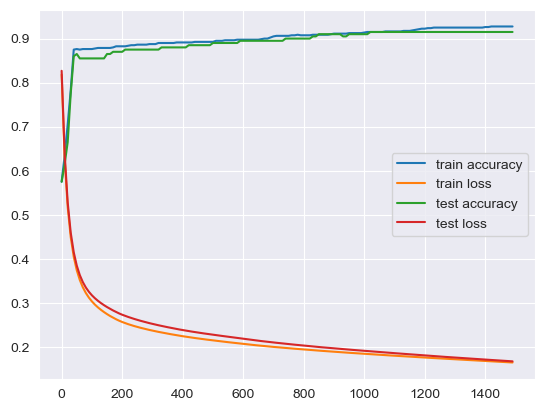

In [4]:
train(x_train, x_test, y_train, y_test)

# Training using **Stochastic Gradient Descent**

Namespace(dnn_hidden_units='20', eval_freq=10, learning_rate=0.01, max_steps=1500, method='SGD')
Epoch 0
Train Accuracy: 0.86375 	 Train Loss: 0.6653996066433708
Test Accuracy: 0.865 	 Test Loss: 0.9018533841985535

Epoch 10
Train Accuracy: 0.905 	 Train Loss: 0.18591682591821074
Test Accuracy: 0.895 	 Test Loss: 0.19513112595020513

Epoch 20
Train Accuracy: 0.94 	 Train Loss: 0.11278433396498828
Test Accuracy: 0.955 	 Test Loss: 0.11836555179428469

Epoch 30
Train Accuracy: 0.99125 	 Train Loss: 0.0481133176850598
Test Accuracy: 0.995 	 Test Loss: 0.05851493725216339

Epoch 40
Train Accuracy: 0.99875 	 Train Loss: 0.026561773718065028
Test Accuracy: 0.995 	 Test Loss: 0.0315580395021972

Epoch 50
Train Accuracy: 1.0 	 Train Loss: 0.018210529096395933
Test Accuracy: 0.995 	 Test Loss: 0.024105266158057134

Epoch 60
Train Accuracy: 1.0 	 Train Loss: 0.01419820113709457
Test Accuracy: 0.995 	 Test Loss: 0.019397839349677478

Epoch 70
Train Accuracy: 1.0 	 Train Loss: 0.009976009999044065

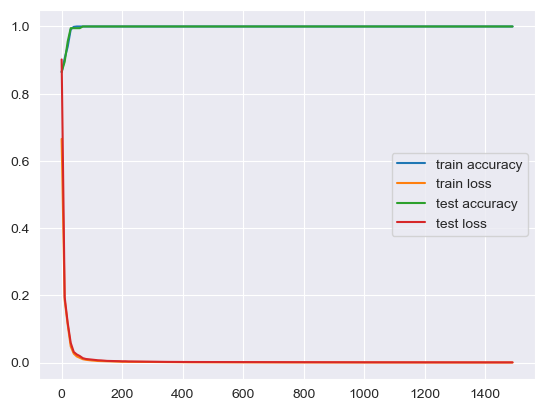

In [5]:
FLAGS.method = 'SGD'
train(x_train, x_test, y_train, y_test)